<a href="https://colab.research.google.com/github/pramitpal/SPI_dataset_creation/blob/main/creating_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ZIP_FILE='/content/drive/MyDrive/StarGan_Depth_pramit.zip'
%mkdir -p ./data/
!unzip '/content/drive/MyDrive/StarGan_Depth_pramit.zip' -d "./data"

Archive:  /content/drive/MyDrive/StarGan_Depth_pramit.zip
   creating: ./data/StarGan Dataset/
   creating: ./data/StarGan Dataset/test/
   creating: ./data/StarGan Dataset/test/color/
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_110636_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_110757_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_110805_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_112351_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_164711_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_164939_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160120_165012_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160122_202327_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160122_204156_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160122_205732_c.png  
  inflating: ./data/StarGan Dataset/test/color/in_00_160122_20583

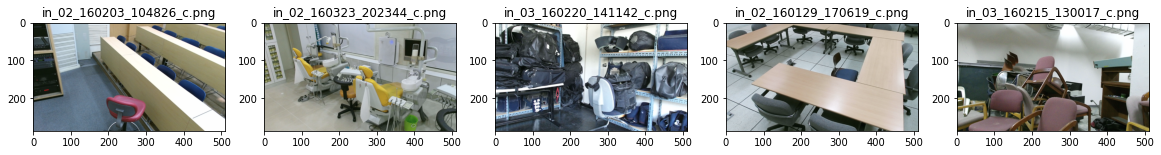

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import random
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(20,20))
img_folder=r'/content/data/StarGan Dataset/train/color'
all_files=os.listdir(img_folder)
for i in range(5):
    file=all_files[i]
    # file = random.choice()
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [ ]:
IMG_WIDTH=256
IMG_HEIGHT=256
img_folder=r'/content/data/StarGan Dataset/train/color/'
def create_dataset(img_folder):
    color_img_data_array=[]
    depth_img_data_array=[]
    name_array=[]
   
    for file in os.listdir(img_folder):
            color_path= os.path.join(img_folder, file)
            depth_path=color_path
            depth_path=depth_path.replace('color', 'depth_vi')
            depth_path=depth_path.replace('_c','_depth_vi')
            name_array.append(color_path)
            # print(depth_path)

            color_image= cv2.imread( color_path, cv2.COLOR_BGR2RGB)
            color_image=cv2.resize(color_image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            color_image=np.array(color_image)
            color_image = color_image.astype('float32')
            color_image /= 255 
            color_img_data_array.append(color_image)

            depth_image= cv2.imread( depth_path, cv2.COLOR_BGR2RGB)
            depth_image=cv2.resize(depth_image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            depth_image=np.array(depth_image)
            depth_image = depth_image.astype('float32')
            depth_image /= 255 
            depth_img_data_array.append(depth_image)

           
    return color_img_data_array, depth_img_data_array,name_array
# extract the image array and class name
color_images,depth_images,name_array=create_dataset(img_folder)

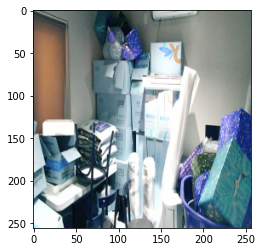

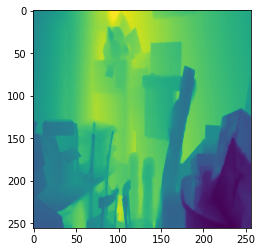

In [ ]:
index=98
plt.figure()
plt.imshow(color_images[index])
plt.figure()
plt.imshow(depth_images[index])
# color_images.shape

In [ ]:
import imageio
from math import *
from skimage import color
from skimage.transform import resize
from scipy.optimize import line_search
from scipy.linalg import hadamard
import itertools

### Correlation modulation method :
Following [1], let $A \in \mathbb{R}^{m\times n}$ denote the light modulation matrix ($m$ denote the number of modulation patterns and $n$ is the pixel count) and $b \in \mathbb{R}^{m\times 1}$ be the measurement vector. We also denote by $x$ the target scene where $x \in \mathbb{R}^{n\times 1}$. Usually, $m \neq n$ which implies that $A$ is not symmetric. This can be overcomed via a multiplication by $A^T$ thus giving the equation : $A^TA x = A^T b$ which can be solved easily in most cases. However, when $m < n$ the matrix $A^T A$ is not of full rank and this technique would not work. 

Using the fact that SPI measures the correlation between the modulation patterns and the target scene, we can reconstruct the image by correlating the measurment patterns with the modulation patterns with the measurements values. The reconstructed scene is then given by : $x = \{b_i\textbf{a}_i\} - \{b_i\}\{\textbf{a}_i\}$ where $b_i$ denotes the $i$-th measurement, $\textbf{a}_i$ is $i$-th row in the modulation matrix and $\{.\}$ denotes the mean operator. 

In [ ]:
def correlation_modulation_method(A, b):
    """ Implements correlation moduation single pixel reconstruction
    
    Inputs : 
        A: Measurements matrix
        b: Measuremets vector
        
    outputs :
        A flattened version of the image
    """
    return np.mean(np.multiply(A,b), axis=0) - np.mean(b) * np.mean(A, axis=0)

### Differential Ghost Imaging (DGI) method : 

The DGI method was proposed as an improvement to the previous one. What sets the two methods apart is that in the DGI method,  we take into account the illumination fluctuations and we measure the intensity of  each illumination pattern. If we denote by $S \in \mathbb{R}^{m\times 1}$ the vector of illumination patterns intensities then the DGI reconstruction is given by the following formula : $x = \{b_i\textbf{a}_i\} - \frac{\{b_i\}}{\{s_i\}} \{s_i\textbf{a}_i\}$

In [ ]:
def DGI(pttrn_mat, b):
    """ Implements Differential ghost imaging single pixel reconstruction
    
    Inputs : 
        pttrn_mat: Patterns matrix
        b: Measuremets vector
         
    outputs : 
        The reconstructed image
    """
    as_mean, ab_mean = 0, 0
    for i in range(pttrn_mat.shape[2]):
        pttrn = pttrn_mat[:, :, i]
        ab_mean = (ab_mean * i + pttrn * b[i])/(i+1)
        as_mean = (as_mean * i + np.sum(pttrn)*pttrn)/(i+1)
    return ab_mean - np.mean(b)/np.mean(np.sum(pttrn_mat, axis =2)) * as_mean

### Gradient descent algorithm 

One can formulate the SPI problem as a minimisation problem where the goal is to reduce the error between the real measurements and the estimated ones. This minilisation problem can be written in the form of a quadratic minimisation problem : $ \min_x L(x) = \min_x\|Ax-b\|_2^2$. 

The gradient of this function can be easily derived : $\nabla L(x) = 2A^T(Ax-b)$. The gradient descent algorithm consist in repeating the following operation: $ x = x - \gamma_x \nabla L(x)$ where $\gamma_x$ denotes the step size. The authors of [1] proved that the optimal step size is given by : $\gamma_x =  \frac{\nabla L(x) A^T (Ax-b)}{\nabla L(x) A^T A \nabla L(x)}$.  The following function implements this algorithm.

In [ ]:
def GD(A, b, max_iter=10000, tol=1e-6, verbose=True):
    """ Implements gradient descent algorithm
    
    Inputs : 
        A : Measurements matrix
        b : Measurements vector
        max_iter : The maximum number of iterations
        tol : The tolerance of needed for the convergence to be reached
        verbose : A flag for printing the threshold and the iterations count
        
    Outputs : 
        A flattened version of the reconstructed image (a vector)
    """
    x =  np.zeros((A.shape[1], 1)) # initial guess
    r, eps, i = b - A@x, 1, 0 #residual and the threshold (set to 1 just for initialisation)
    while(i<=max_iter and eps>tol):
        grad = -2*A.T@r # gradient computation 
        step = -grad.T@A.T@r/(grad.T@A.T@A@grad) # Optimal step
        x -= step*grad # gradient descent step 
        eps, r = r, b - A@x # updating the residual
        eps = np.abs(np.linalg.norm(eps) - np.linalg.norm(r)) # Computing the threshold
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))
        i += 1
    return (x-np.min(x))/(np.max(x)-np.min(x))

### Conjugate gradient descent 

The conjugate gradient descent method solves the same minimisation problem as the gradient descent but it requires that the $A$ be symmetric and positive. The trick is to use a multiplication of a factor of $A^T$ to get the following equation : $A^TAx = A^Tb \rightarrow A^{'}x = b^{'}$. Let $r^k = b^{'} - A^{'} x^k$ denote the residual error vector at iteration $k$
then the gradient at iteration $k$ is given by : $\nabla L(x^k) = -r^{(k-1)} - \frac{{r^{(k-1)}}^T r^{(k-1)}}{{r^{(k-2)}}^T r^{(k-2)}} \nabla L(x^{(k-1)})$. The optimal step size is obtained using the following formula : $\gamma_x^k = \frac{{r^{(k-1)}}^T r^{(k-1)}}{{\nabla L(x^k)}^T A^{'} \nabla L(x^k)}$. Theoretically, the conjugate gradient descent should converge in no more than $n$ steps to the reconstructed scene.


In [ ]:
def CGD(A, b, max_iter=10000, tol=1e-6, verbose=True):
    """ Implements conjugate gradient descent algorithm
      
    Inputs : 
        A : Measurements matrix
        b : Measurements vector
        max_iter : The maximum number of iterations
        tol : the tolerance of needed for the convergence to be reached
        verbose : A flag for printing the threshold and the iterations count
        
    Outputs : 
        A flattened version of the reconstructed image (a vector)
    """
    x, A, b =  np.ones((A.shape[1], 1)), A.T@A, A.T@b # initial guess and input transformation
    r, i= b - A@x, 0
    r_prev, grad, eps = r, r, np.linalg.norm(r)
    while(i<=max_iter and eps>tol):
        i += 1
        step = r.T@r / (grad.T@A@grad) # Optimal step computation
        x += step*grad #gradient descent step (inversed sign in the step explains the +)
        r = b - A@x # residual computation
        grad = r + (r.T@r/(r_prev.T@r_prev))*grad # gradient computation 
        eps = np.abs(np.linalg.norm(r)-np.linalg.norm(r_prev)) 
        r_prev = r
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [ ]:
# Global parameters needed for the reconstruction algs
pxl_cnt = 64 # pixel count in each dimension of the image
smpl_ratio = 1 #sampling ratio

In [ ]:
# %mkdir images

Original Grey-level image data shape :  (256, 256)
Resized Grey-level image data shape :  (64, 64)


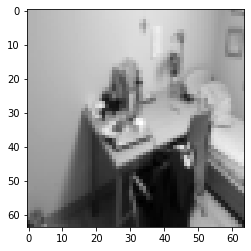

In [ ]:
# Reading an input image
# file_name = '/content/images/ghost.png' # select the image name
i=10
img_in=color_images[i]
# img_in = imageio.imread(file_name)# Read the image
img_gray = color.rgb2gray(img_in) # converting to gray scale

print('Original Grey-level image data shape : ', img_gray.shape) # the original shape of the image
img_rsz = resize(img_gray, (pxl_cnt, pxl_cnt), order=1,
                 preserve_range=True, anti_aliasing=True) # Resiwing to the desired size
print('Resized Grey-level image data shape : ', img_rsz.shape) # the original shape of the image
plt.imshow(img_rsz,cmap='gray');

In [ ]:

pttrn_cnt = round(smpl_ratio*pxl_cnt**2) #The number of illumination patterns
pttrn_mat =  np.random.uniform(low=0.0, high=1.0,
                              size=(pxl_cnt, pxl_cnt, pttrn_cnt)) # Computing the patters, uniform distribution
# Computing the measurements
measurements = np.sum(np.sum(np.multiply(np.tile(img_rsz[:, :, np.newaxis], [1, 1, pttrn_cnt]), pttrn_mat), axis=0), axis=0)
measurements = measurements.reshape(-1, 1)
# Initialisation
rows, cols, lyrs = pttrn_mat.shape
A = pttrn_mat.reshape(rows*cols, lyrs).T

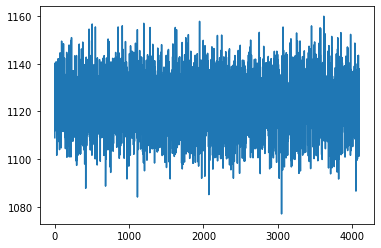

In [ ]:
plt.plot(measurements)

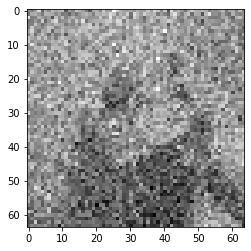

In [ ]:
plt.imshow(DGI(pttrn_mat, measurements).reshape(pxl_cnt, pxl_cnt), cmap='gray')

Reconstructing using the CGD method. 

Iteration number 10 out of 10000, the error is 1543.0948842906425
Iteration number 20 out of 10000, the error is 7.641071686654406
Iteration number 30 out of 10000, the error is 1398.9962243152506
Iteration number 40 out of 10000, the error is 64.17935236410172
Iteration number 50 out of 10000, the error is 0.7122224418104501
Iteration number 60 out of 10000, the error is 52.3686410944772
Iteration number 70 out of 10000, the error is 297.18396533896066
Iteration number 80 out of 10000, the error is 0.11797952831195246
Iteration number 90 out of 10000, the error is 0.10208087536649124
Iteration number 100 out of 10000, the error is 0.11234246888175159
Iteration number 110 out of 10000, the error is 44.981919165878196
Iteration number 120 out of 10000, the error is 2.0647808509661134
Iteration number 130 out of 10000, the error is 36.96713228242452
Iteration number 140 out of 10000, the error is 0.30175443793181356
Iteration number 150 out of 10000

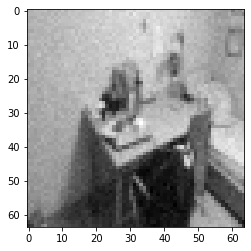

In [ ]:
# SPI conjugate gradient descent (CGD) reconstruction
print('Reconstructing using the CGD method. \n');
res = CGD(A, measurements, max_iter=10000, tol=1e-3).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');

MAKE images dataset using DGI

In [ ]:
%mkdir '/content/data/StarGan Dataset/train/SPI'

In [ ]:
def make_DGI_dataset(img_array,name_arr,smpl_ratio,pxl_cnt,method='DGI',num=-1):
  img_data_array=[]
  n=len(img_array)
  if num != -1:
    n=num
  for i in range(n):
    img_in=img_array[i]
    # img_in = imageio.imread(file_name)# Read the image
    img_gray = color.rgb2gray(img_in) # converting to gray scale
    # print('Original Grey-level image data shape : ', img_gray.shape) # the original shape of the image
    img_rsz = resize(img_gray, (pxl_cnt, pxl_cnt), order=1,
                 preserve_range=True, anti_aliasing=True) # Resiwing to the desired size
    # print('Resized Grey-level image data shape : ', img_rsz.shape) # the original shape of the image
    # plt.imshow(img_rsz,cmap='gray');
    #############
    
    pttrn_cnt = round(smpl_ratio*pxl_cnt**2) #The number of illumination patterns
    pttrn_mat =  np.random.uniform(low=0.0, high=1.0,
                              size=(pxl_cnt, pxl_cnt, pttrn_cnt)) # Computing the patters, uniform distribution
    # Computing the measurements
    measurements = np.sum(np.sum(np.multiply(np.tile(img_rsz[:, :, np.newaxis], [1, 1, pttrn_cnt]), pttrn_mat), axis=0), axis=0)
    measurements = measurements.reshape(-1, 1)
    # Initialisation
    rows, cols, lyrs = pttrn_mat.shape
    A = pttrn_mat.reshape(rows*cols, lyrs).T
    #####################

    if method == 'DGI':
      out_img=DGI(pttrn_mat, measurements).reshape(pxl_cnt, pxl_cnt)
    elif method == 'CGD':
      out_img=CGD(A, measurements, max_iter=10000, tol=1e-3,verbose=False).reshape(pxl_cnt, pxl_cnt)
    else:
      print('check method name')

    name=name_arr[i].replace('color', 'SPI')
    name=name.replace('_c','_SPI')
    out_img=np.multiply(out_img,255)
    cv2.imwrite(name, out_img)
    print(name)

    # img_data_array.append(out_img)
  # return img_data_array

make_DGI_dataset(color_images,name_array,0.5,64,method='CGD')



/content/data/StarGan Dataset/train/SPI/in_02_160203_104826_SPI.png
/content/data/StarGan Dataset/train/SPI/in_02_160323_202344_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160220_141142_SPI.png
/content/data/StarGan Dataset/train/SPI/in_02_160129_170619_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160215_130017_SPI.png
/content/data/StarGan Dataset/train/SPI/in_02_160129_150648_SPI.png
/content/data/StarGan Dataset/train/SPI/in_01_160204_145017_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160128_161111_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160215_125540_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160225_120523_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160215_104032_SPI.png
/content/data/StarGan Dataset/train/SPI/in_00_160324_164833_SPI.png
/content/data/StarGan Dataset/train/SPI/in_00_160225_144404_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_160203_152246_SPI.png
/content/data/StarGan Dataset/train/SPI/in_03_16

In [ ]:
import shutil
shutil.make_archive('/content/drive/MyDrive/Gan_spi_dataset', 'zip', '/content/data/StarGan Dataset')

'/content/drive/MyDrive/Gan_spi_dataset.zip'